In [2]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
from hexplot import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


# Read data and pre-process for analysis

In [3]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]


In [4]:
lineage_sizes = df.groupby(['donor','lineage_id']).size().to_dict()
df['lineage_size'] = df.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)
lineage_sizes = df_clean.groupby(['donor','lineage_id']).size().to_dict()
df_clean['lineage_size'] = df_clean.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)


In [5]:
v_mismatch_dict = df[['vdj_sequence', 
                      'v_mismatch']].drop_duplicates(ignore_index=True).set_index('vdj_sequence')
v_mismatch_dict = v_mismatch_dict.to_dict()['v_mismatch']

# First plot hexplot for visualization

TBd6 4009
LN    25683
PB    10386
SP     9047
BM     4009
Name: tissue, dtype: int64


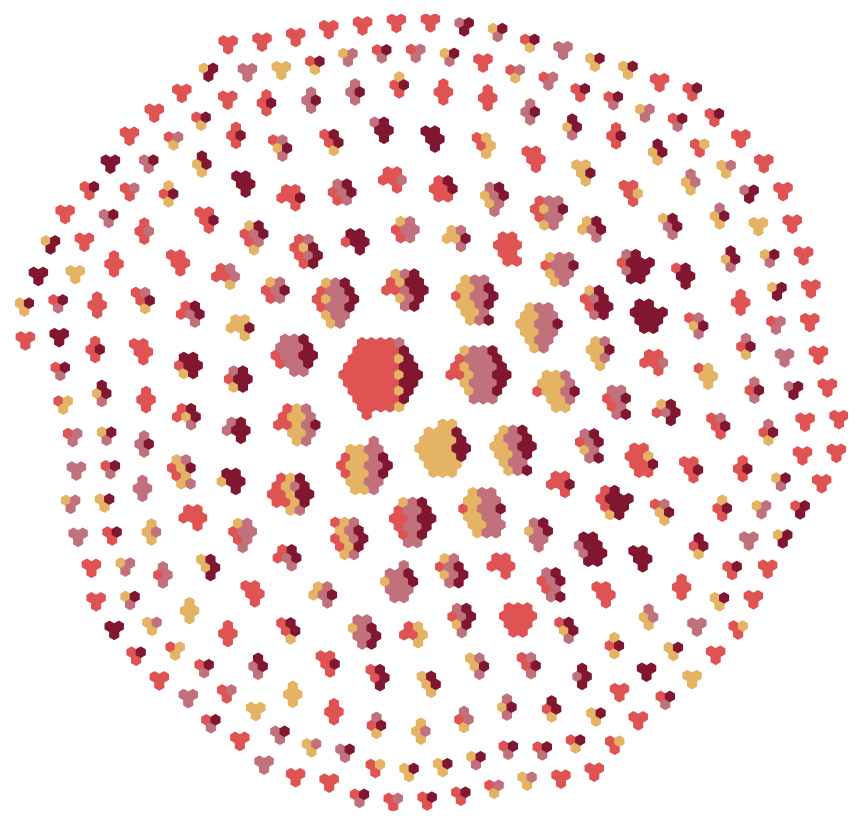

In [16]:
target_donor='TBd6'
ddf = df_clean[(df_clean.donor==target_donor)]
n = ddf.groupby(['tissue']).size().min()
print(target_donor, n)
print(ddf.tissue.value_counts())
ddf = ddf.groupby('tissue').sample(n=n, replace=False).reset_index()
lineage_sizes = ddf.groupby(['donor','lineage_id']).size().to_dict()
ddf['lineage_size'] = ddf.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                                axis=1)
ddf = ddf[ddf.lineage_id.notna()]
fig, ax, new_ddf = plot_hexplot(ddf[ddf.lineage_size>2],
                    group_col='lineage_id',
                    hue='tissue',
                    sort='tissue',
                    cmap=None,
                    palette=tissue_colors)
fig.savefig(f'{FIGURE_OUTDIR}/Figure4a.pdf', bbox_inches='tight')

# Calculate distribution of lineage members between tissues

In [ ]:
df = df[['vdj_sequence','donor','tissue','lineage_id']].drop_duplicates(ignore_index=True)
df['lineage_uid'] = df['donor'] + "_" + df['lineage_id'].astype(str)
df['donor_tissue'] = df['donor'] + "_" + df['tissue']
n = df.groupby(['donor_tissue']).size().min()
df_downsampled = df.groupby('donor_tissue').sample(n=n, replace=False).reset_index()
permutations = {}
for i in range(100):
    permut = pd.Series('', index=df_downsampled.index)
    for donor in donors:
        donor_subset = df_downsampled.donor==donor
        subset_size = donor_subset.sum()
        permut.loc[donor_subset] = np.random.choice(df_downsampled.loc[donor_subset,'donor_tissue'].values, 
                                                       size = subset_size)
    permutations.update({f'permut_{i}':permut})
permutations = pd.DataFrame(permutations)
df_downsampled = df_downsampled.merge(permutations, left_index=True, right_index=True)
all_samples = df.donor_tissue.unique()


In [ ]:
def calculate_tissue_fractions(df, 
                               lineage_col='lineage_uid', 
                               tissue_col='donor_tissue',
                               unique_identifier_col='vdj_sequence'):
    lcol = lineage_col
    tcol = tissue_col
    uid_col = unique_identifier_col
    
    total_counts = df.groupby([lcol])[uid_col].nunique()
    tissue_counts = df.groupby([lcol,tcol])[uid_col].nunique()
    tissue_counts = tissue_counts.reset_index().pivot(index=lcol, columns=tcol, values=uid_col)
    donor_columns = [x for x in tissue_counts.columns if x.startswith("TB")]

    tissue_fractions = tissue_counts[donor_columns].copy()    
    tissue_fractions = (tissue_fractions.T/total_counts).T
    
    return tissue_fractions, total_counts

In [ ]:
all_tissue_fractions_data, total_counts = calculate_tissue_fractions(df_downsampled)
all_tissue_fractions_resampled, total_counts_resampled = calculate_tissue_fractions(df_downsampled, tissue_col='permut_0')

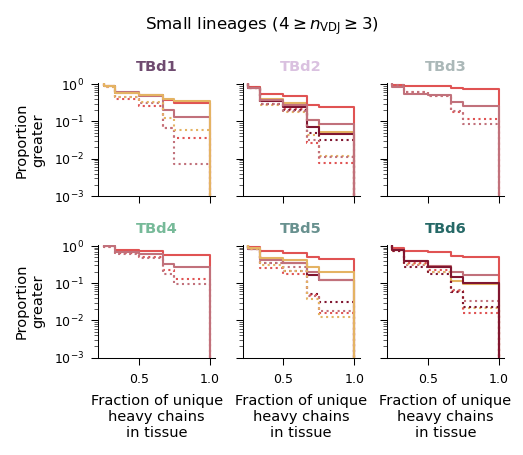

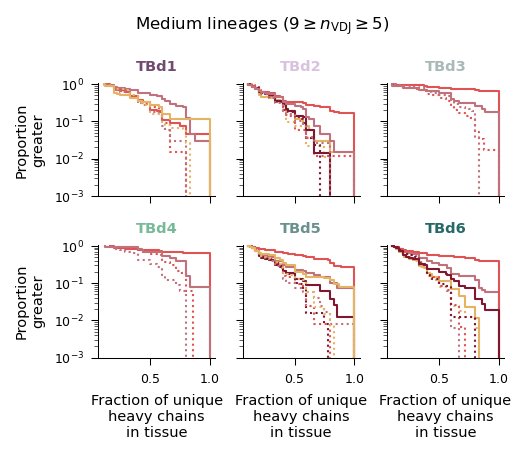

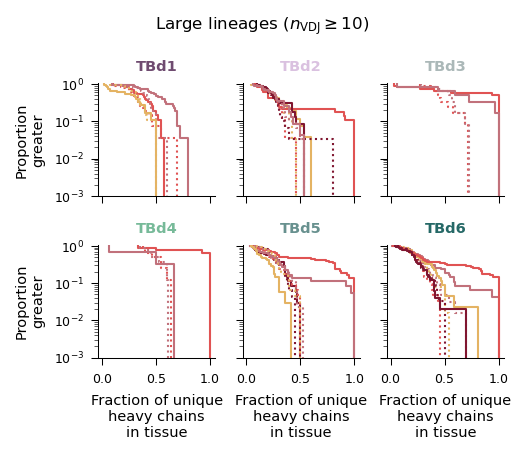

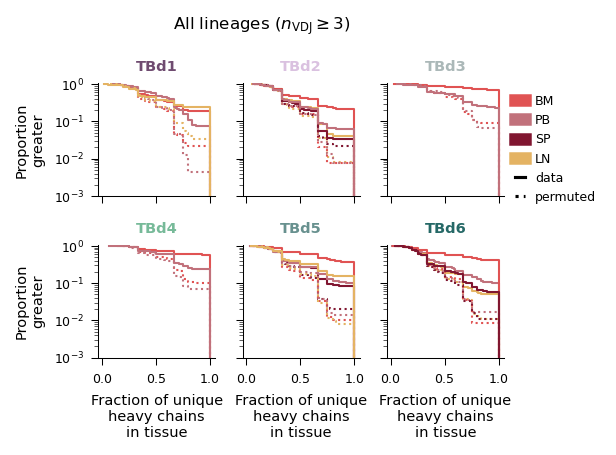

In [ ]:


small_lineages = lambda x: (x < 5) & (x > 2)
medium_lineages = lambda x: (x < 10) & (x > 4)
large_lineages = lambda x: (x > 9)
all_lineages = lambda x: (x > 2)


cats = [(r"Small lineages ($4\geq  n_\mathrm{VDJ}\geq 3$)", small_lineages),
        (r"Medium lineages ($9\geq n_\mathrm{VDJ} \geq 5$)", medium_lineages), 
        (r"Large lineages ($ n_\mathrm{VDJ}\geq 10$)", large_lineages),
        (r"All lineages ($ n_\mathrm{VDJ}\geq 3$)", all_lineages)]

for name, subset_lambda in cats:
    fig, axes = plt.subplots(2,3, figsize=(3.5,3), sharey=True, sharex=True)
    axes = axes.flatten()
    bins=np.linspace(0,1,20)
    tissue_fractions_data=all_tissue_fractions_data[subset_lambda(total_counts)]
    tissue_fractions_resampled = all_tissue_fractions_resampled[subset_lambda(total_counts_resampled)]
    fig.suptitle(f"{name}", fontsize=8)
    donors= sorted(list(donor_colors.keys()))
    for it, donor in enumerate(donors):
        ax = axes[it]
        ax.set_title(donor, weight='bold', color=donor_colors[donor])
        donor_columns = [x for x in all_samples if x.startswith(donor)] 
        for col in donor_columns:
            sns.ecdfplot(tissue_fractions_data[col],
                         # bins=bins,
                         # kde=False,
                         # element='poly',
                         # fill=False,
                         # stat='probability',
                        complementary=True, 
                        log_scale=(False,True), 
                        ax=ax, 
                        color=tissue_colors[col[-2:]])
            sns.ecdfplot(tissue_fractions_resampled[col],
                         # bins=bins,
                         # kde=False,
                         # element='poly',
                         # fill=False,
                         # stat='probability',
                        complementary=True, 
                        log_scale=(False,True), 
                        ax=ax, 
                        color=tissue_colors[col[-2:]],
                        linestyle='dotted')
        ax.set_ylim([10**-3, 1.05])
        ax.set_xlabel('Fraction of unique\nheavy chains\nin tissue')
        ax.set_ylabel('Proportion\ngreater')
    sns.despine(fig)
    fig.tight_layout()
for tissue in ['BM','PB','SP','LN']:
    axes[2].plot([],[],label=tissue, lw=6, color=tissue_colors[tissue])
axes[2].plot([],[], color='k', lw=1.5, label='data')
axes[2].plot([],[], color='k', lw=1.5, label='permuted', linestyle='dotted')
axes[2].legend(bbox_to_anchor=(1,1), frameon=False, handlelength=0.8)
fig.savefig(f'{FIGURE_OUTDIR}/Figure4b.pdf', bbox_inches='tight')

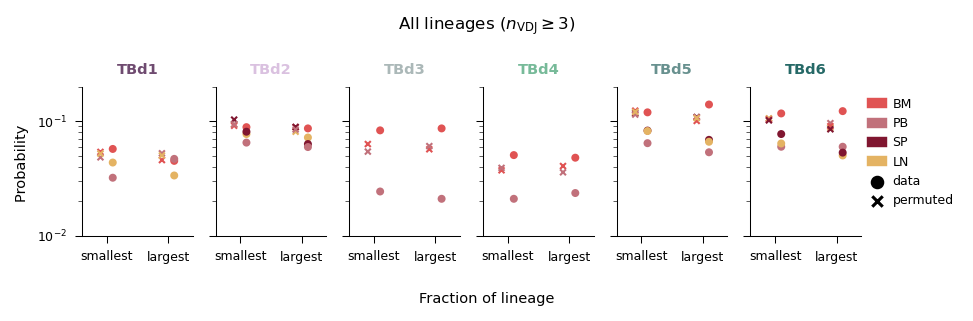

In [ ]:

small_lineages = lambda x: (x < 5) & (x > 2)
medium_lineages = lambda x: (x < 10) & (x > 4)
large_lineages = lambda x: (x > 9)
all_lineages = lambda x: (x > 2)

cats = [(r"All lineages ($ n_\mathrm{VDJ}\geq 3$)", all_lineages)]


for name, subset_lambda in cats:
    fig, axes = plt.subplots(1,6, figsize=(6.5,2), sharey=True, sharex=True)
    axes = axes.flatten()
    bins=np.linspace(0,1,20)
    tissue_fractions_data=all_tissue_fractions_data[subset_lambda(total_counts)]
    tissue_fractions_resampled = all_tissue_fractions_resampled[subset_lambda(total_counts_resampled)]
    fig.suptitle(f"{name}",fontsize=8)
    donors= sorted(list(donor_colors.keys()))
    for it, donor in enumerate(donors):
        ax = axes[it]
        ax.set_title(donor, weight='bold', color=donor_colors[donor])
        donor_columns = [x for x in all_samples if x.startswith(donor)] 
        for data_frame, marker, offset in [(tissue_fractions_data,'o', 0.1),
                                   (tissue_fractions_resampled,'x', -0.1)]:
            is_greatest = (data_frame[donor_columns].T == data_frame[donor_columns].max(axis=1).values).T
            is_smallest = (data_frame[donor_columns].T == data_frame[donor_columns].min(axis=1).values).T
            has_any = data_frame[donor_columns].notna()

            yvals = (is_greatest.sum()/is_greatest.shape[0]).values
            colors = [tissue_colors[x[-2:]] for x in (is_greatest.sum()/is_greatest.shape[0]).index]
            xvals = 2*np.ones(len(yvals))+offset #+ (it-3)*0.5
            ax.scatter(xvals, yvals, marker=marker, color=colors, s=8)


            yvals = (is_smallest.sum()/is_smallest.shape[0]).values
            colors = [tissue_colors[x[-2:]] for x in (is_smallest.sum()/is_smallest.shape[0]).index]
            xvals =1* np.ones(len(yvals))+offset #+ (it-3)*0.5
            ax.scatter(xvals, yvals, marker=marker, color=colors, s=8)


#             yvals = (has_any.sum()/has_any.shape[0]).values
#             colors = [tissue_colors[x[-2:]] for x in (has_any.sum()/has_any.shape[0]).index]
#             xvals = 0* np.ones(len(yvals))+offset
#             ax.scatter(xvals, yvals, marker=marker, color=colors)
        
        ax.set_xticks([2,1], ['largest', 'smallest'])
        ax.set_yscale('log')
        ax.set_ylim([10**-2, 0.2])
        # ax.set_xlabel('Fraction of lineage', weight='bold')
        ax.set_xlim([0.6,2.4])
    sns.despine(fig)
axes[0].set_ylabel('Probability ', fontsize=7, x= 0.43)
fig.supxlabel('Fraction of lineage', fontsize=7)

for tissue in ['BM','PB','SP','LN']:
    axes[5].plot([],[],label=tissue, lw=5, color=tissue_colors[tissue])
axes[5].scatter([],[], marker='o',color='k', lw=1.5, label='data')
axes[5].scatter([],[], marker='x',color='k', lw=1.5, label='permuted')
axes[5].legend(bbox_to_anchor=(1,1), frameon=False, handlelength=0.8)
fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/Figure4e.pdf', bbox_inches='tight')